# Simulación de Frenado Crítico y Dinámica de Colisión

Este proyecto analiza la relación no lineal entre la distancia de seguridad y la severidad de un impacto. Mediante el uso de Python, se modela cómo variables externas (coeficiente de fricción $\mu$) y factores biológicos (tiempo de reacción $t_{reacción}$) transforman una frenada controlada en una colisión inevitable.

In [15]:
import numpy as np
import matplotlib.pyplot as plt

Definimos las constantes para que sea más simple de replicar

In [16]:
g = 9.81
mu = 0.6
m1 = 1200
m2 = 1000
v1_0 = 100 / 3.6
v2_0 = 0
e = 0.3
t_reaccion = 0.75
dt = 0.001
distancias = np.linspace(1, 100, 50)

## Simulación de frenado

In [17]:
a = -mu * g
x = 0
t = 0 
df_a = 20 
v0 = 70 / 3.6
v_lista = [v0] 

while x < df_a:
    v_actual = v_lista[-1] 
    v_nueva = max(0, v_actual + a*dt) 
    v_lista.append(v_nueva) 
    t += dt
    x = x + v_nueva*dt
    if v_nueva <= 0:
        break
print(v_lista[-1], x)

11.939794444444086 20.003699966666442


### Definimos la función de frenado

In [18]:
def frenado(mu,df,v_inicial):
    a = -mu * g
    x = 0
    t = 0
    dt = 0.001
    v_total = [v_inicial]
    while x < df:
        v_actual = v_total[-1]
        v_nueva = max(0, v_actual + a*dt)
        v_total.append(v_nueva)
        t += dt
        x = x + v_nueva*dt
        if v_nueva == 0:
            break
    return v_total[-1]

### Definimos la función del choque de los vehículos

In [19]:
# Choque inelástico (instantáneo)
def choque(m1,m2,v1,v2,e):
    v1_f = (m1*v1 + m2*v2 - m2*e*(v1-v2)) / (m1+m2)
    v2_f = (m1*v1 + m2*v2 + m1*e*(v1-v2)) / (m1+m2)
    return v1_f,v2_f
choque(1000, 500, 16.7, 0, 0.2)

(10.02, 13.36)

### Unificamos ambas funciones en una única función

In [20]:
def choque_con_frenado(mu,df1,df2,v1,v2,m1,m2,e):
    return choque(m1,m2,frenado(mu,df1,v1),frenado(mu,df2,v2),e)


### Usamos la función para ver como afecta la distancia de frenado a la velocidad de choque

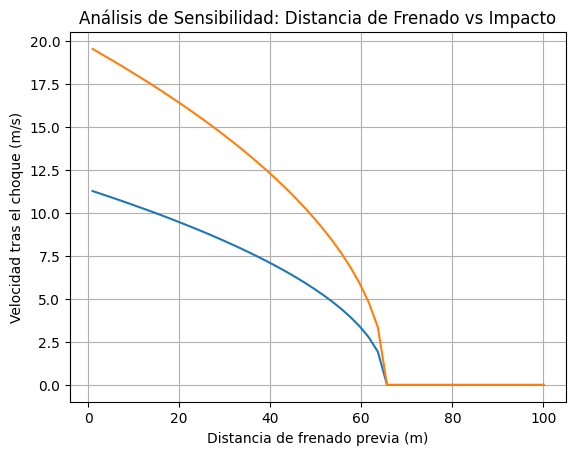

In [21]:
resultados =[] 
for i in distancias:
    resultados.append(choque_con_frenado(mu, i, 0, v1_0, v2_0, m1, m2, e))

plt.plot(distancias, resultados) 
plt.title("Análisis de Sensibilidad: Distancia de Frenado vs Impacto")
plt.xlabel("Distancia de frenado previa (m)")
plt.ylabel("Velocidad tras el choque (m/s)")
plt.grid(True)
plt.show()

> **Nota:** la recta azul representa la velocidad final del vehículo 1 tras el impacto, mientras que la recta naranja corresponde a la velocidad final del vehículo 2.

### Factor humano: Tiempo de reacción

Introducimos el tiempo de reacción humano a la función de frenado

In [22]:
def frenado_con_reaccion(mu,df,v_inicial):
    a = -mu * g
    x = t_reaccion*v_inicial
    if x>=df:
        return v_inicial
    t = t_reaccion
    dt = 0.001
    v_total = [v_inicial]
    while x < df:
        v_actual = v_total[-1]
        v_nueva = max(0, v_actual + a*dt)
        v_total.append(v_nueva)
        t += dt
        x = x + v_nueva*dt
        if v_nueva == 0:
            break
    return v_total[-1]

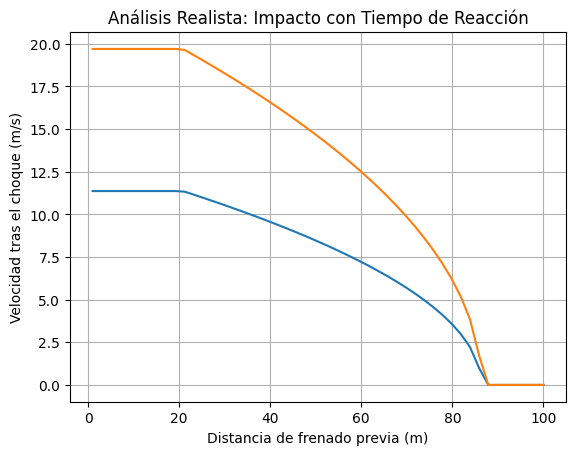

In [28]:
def choque_con_frenado_reacción(mu,df1,df2,v1,v2,m1,m2,e):
    return choque(m1,m2,frenado_con_reaccion(mu,df1,v1),frenado_con_reaccion(mu,df2,v2),e)

resultados_reaccion = []
for i in distancias:
    resultados_reaccion.append(choque_con_frenado_reacción(mu, i, 0, v1_0, v2_0, m1, m2, e))

plt.plot(distancias, resultados_reaccion)
plt.title("Análisis Realista: Impacto con Tiempo de Reacción")
plt.xlabel("Distancia de frenado previa (m)")
plt.ylabel("Velocidad tras el choque (m/s)")
plt.grid(True)
plt.show()

> **Nota:** la recta azul representa la velocidad final del vehículo 1 tras el impacto, mientras que la recta naranja corresponde a la velocidad final del vehículo 2.

## Conclusiones

### El “muro” de la reacción
- Incluso con frenos perfectos, durante los primeros **20,8 m** (a **100 km/h**) la velocidad de impacto **no baja ni 1 km/h**: el conductor aún no ha reaccionado.
- Esto explica por qué muchos alcances en ciudad son **inevitables** si no se mantiene la distancia.

### Distancia de seguridad real
- **Sin reacción:** parada en **65 m**  
- **Con reacción:** se necesitan **~87 m**

Por lo que el factor humano añade **≈33%** más de distancia necesaria.  
A **100 km/h**, cualquier distancia < **90 m** implica **riesgo real de choque**.

### Transferencia de energía (Coche 1 vs Coche 2)
- El **Coche 2 (naranja)** sale proyectado a **mayor velocidad** que la velocidad final del **Coche 1 (azul)**.
- Esto valida el **efecto latigazo**: el coche delantero absorbe el impulso y **acelera bruscamente**.

### Relación No Lineal y Riesgo
- Debido a que la energía cinética depende del cuadrado de la velocidad ($E_c = \frac{1}{2} m v^2$), la distancia necesaria para frenar no aumenta de forma lineal, como se ve en la gráfica
- La energía que tiene que frenar el coche crece mucho más rápido que la velocidad; por eso, si vas al doble de rápido, no necesitas el doble de distancia para parar, sino cuatro veces más. Según los datos de la gráfica con tiempo de reacción, a 100 km/h necesitas al menos 90 metros para no chocar. Si la carretera solo te permite ver a 50 o 60 metros, la velocidad segura debería ser de 80 km/h. Al bajar solo 20 km/h la velocidad inicial, el coche gana muchísima capacidad de frenado, lo que marca la diferencia entre un choque fuerte y lograr detenerse a tiempo antes del obstáculo.

## Estudio de la infuencia de materiales de distinto coeficiente de rozamiento

En este apartado analizamos cómo afecta la calidad del firme (el asfalto) a la seguridad vial en dos escenarios críticos: **autovía** y **zona urbana**. No todas las carreteras requieren el mismo tipo de material; esta simulación busca identificar **dónde es más rentable invertir en pavimentos de alta adherencia**.

Para ello, variamos el coeficiente de rozamiento (\(\mu\)) desde **0.1** (hielo o lluvia extrema) hasta **1.0** (asfalto de competición en condiciones óptimas). Evaluamos el impacto bajo las siguientes premisas:

- **Autovía:** velocidad de **120 km/h** con una distancia de seguridad de **100 m**.  
- **Vía urbana:** velocidad de **50 km/h** con una distancia de seguridad de **25 m**.

El objetivo es identificar el **punto de corte** (coeficiente mínimo \(\mu\)) necesario en cada vía para que la **velocidad de impacto sea cero**, optimizando así los recursos en la construcción de infraestructuras.


In [36]:
def v_fricción(df1,df2,v1_0,v2_0):
    materiales = np.linspace(0,1,10)
    resultados_materiales = []
    for i in materiales:
        resultados_materiales.append(choque_con_frenado_reacción(i, df1, df2, v1_0, v2_0, m1, m2, e))
    plt.plot(materiales, resultados_materiales)
    plt.title("Análisis Realista: Impacto con distintos materiales")
    plt.xlabel("Coeficiente de rozamiento del material")
    plt.ylabel("Velocidad tras el choque (m/s)")
    plt.grid(True)
    plt.show()

### Autovía / Autopista

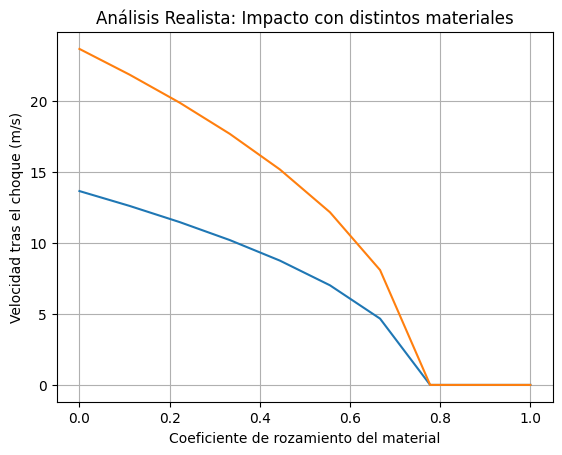

In [38]:
v_fricción(100,0,120 / 3.6,0)

### Vía Urbana

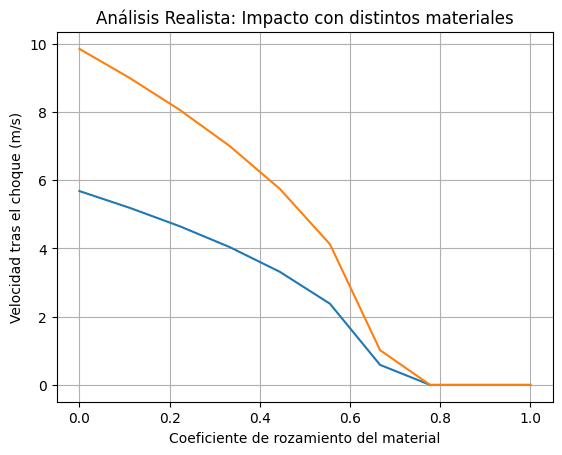

In [40]:
v_fricción(25,0,50 / 3.6,0)

### Comparativa final de materiales

**Punto de corte común**  
Curiosamente, en ambos escenarios se requiere un coeficiente de  
\(\mu \approx 0.78\) para evitar el impacto total.  
Esto demuestra que las distancias de seguridad actuales están calculadas **al límite de la adherencia del neumático**.

**Gravedad del error**  
La diferencia real radica en la consecuencia de usar un material mediocre:
- En **zona urbana**, bajar la calidad del asfalto aumenta la velocidad de impacto de **0 a 10 m/s**.
- En **autovía**, esa misma pérdida de calidad dispara la velocidad de impacto a **más de 20 m/s**, lo que multiplica por cuatro la energía del choque 
 
   $E_c = \frac{1}{2} m v^2$


**Veredicto**  
Invertir en **asfalto premium** es prioritario en autovías, ya que el margen de error que ofrece el material es lo único que separa un alcance leve de un **accidente mortal** a altas velocidades.


> **Nota técnica — Relación neumático–pavimento:** el coeficiente de rozamiento (\(\mu\)) no es una propiedad exclusiva del asfalto, sino el resultado de la **interacción neumático–superficie**. En esta simulación, valores altos (\(\mu > 0.7\)) asumen neumáticos en **condiciones óptimas** de dibujo y presión.  
> En la práctica, neumáticos desgastados pueden reducir el comportamiento efectivo a \(\mu < 0.4\) incluso sobre asfalto de alta calidad, **invalidando los márgenes de seguridad** calculados. Por ello, la efectividad de invertir en infraestructuras premium depende directamente del **mantenimiento del parque móvil**.


### Conclusión del análisis

A través de este modelo físico-matemático, se ha demostrado que la seguridad vial no depende de un único factor, sino de la interdependencia entre la velocidad, el tiempo de respuesta humano y la ingeniería de materiales. El análisis evidencia que la inversión en infraestructuras de alta adherencia es una medida crítica de salvamento en vías de alta velocidad, mientras que en entornos urbanos, la prevención reside fundamentalmente en el factor humano y el control de los límites de velocidad.